## Cleaning Data (API Called) 6950 data points)

In [25]:
#import visualization tools for subsequent analysis
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('movieDB_API_movies.csv') # read in original csv
df = df.drop(columns='Unnamed: 0') # drop useless column identical-to-index column

# code below create gross_profit column for all non 0 budget and revenue (revenue - budget) & create csv
df['gross_profit'] = df[(df['revenue'] != 0) & (df['budget'] != 0)]['revenue'] -df[(df['revenue'] != 0) & (df['budget'] != 0)]['budget']
# pd.DataFrame(df).to_csv('movieDB_API_movies_w_gross_profits.csv') #Turn into csv file for easy access

In [26]:
df.head() # this is what our data looks like

,budget,genres,id,imdb_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,gross_profit
0,13200000,"['Comedy', 'Drama', 'Romance']",19404,tt0112870,17.437,1995-10-20,100000000,190.0,Dilwale Dulhania Le Jayenge,8.8,2214,86800000.0
1,25000000,"['Drama', 'Crime']",278,tt0111161,35.028,1994-09-23,28341469,142.0,The Shawshank Redemption,8.7,15045,3341469.0
2,6000000,"['Drama', 'Crime']",238,tt0068646,29.433,1972-03-14,245066411,175.0,The Godfather,8.7,11486,239066411.0
3,11363000,"['Comedy', 'Thriller', 'Drama']",496243,tt6751668,176.819,2019-05-30,201055038,132.0,Parasite,8.6,4751,189692038.0
4,22000000,"['Drama', 'History', 'War']",424,tt0108052,19.641,1993-11-30,321365567,195.0,Schindler's List,8.6,9163,299365567.0


In [24]:
df.info() # 6950 no missing data apparently, 4273/6950 have gross_profit (61% of data can use profit metric)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6950 entries, 0 to 6949
Data columns (total 12 columns):
budget          6950 non-null int64
genres          6950 non-null object
id              6950 non-null int64
imdb_id         6949 non-null object
popularity      6950 non-null float64
release_date    6950 non-null object
revenue         6950 non-null int64
runtime         6937 non-null float64
title           6950 non-null object
vote_average    6950 non-null float64
vote_count      6950 non-null int64
gross_profit    4273 non-null float64
dtypes: float64(4), int64(4), object(4)
memory usage: 651.6+ KB


## What do we do with rows with missing gross profits?

#### Create subset of data points with gross profit. We have 4273/6950 data points that have a calculated gross profit. We will analyze our data to learn more about and see if there's other data we need. We won't remove the 0 values but we won't use them now.

In [43]:
df = df[df['gross_profit'].notna()]

## What are the genres?

In [45]:
# What genres do we have?
## 1625 unique combinations of genres

# Top 3 Genres?
## Comedy 552/1625 or 34%
## Drama 419/1625 or 26%
## (Drama + Romance) 195/1625 or 12%
1
#showing first ten genres
df['genres'].value_counts()[0:10] #we should keep the combinations... They're important

['Comedy']                        237
['Drama']                         234
['Drama', 'Romance']              114
['Comedy', 'Romance']             106
['Horror', 'Thriller']             91
['Comedy', 'Drama']                85
['Comedy', 'Drama', 'Romance']     79
['Horror']                         69
['Drama', 'Thriller']              52
['Action', 'Thriller']             45
Name: genres, dtype: int64

## What's the distribution of movie popularity?

In [46]:
df.head()

,budget,genres,id,imdb_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,gross_profit
0,13200000,"['Comedy', 'Drama', 'Romance']",19404,tt0112870,17.437,1995-10-20,100000000,190.0,Dilwale Dulhania Le Jayenge,8.8,2214,86800000.0
1,25000000,"['Drama', 'Crime']",278,tt0111161,35.028,1994-09-23,28341469,142.0,The Shawshank Redemption,8.7,15045,3341469.0
2,6000000,"['Drama', 'Crime']",238,tt0068646,29.433,1972-03-14,245066411,175.0,The Godfather,8.7,11486,239066411.0
3,11363000,"['Comedy', 'Thriller', 'Drama']",496243,tt6751668,176.819,2019-05-30,201055038,132.0,Parasite,8.6,4751,189692038.0
4,22000000,"['Drama', 'History', 'War']",424,tt0108052,19.641,1993-11-30,321365567,195.0,Schindler's List,8.6,9163,299365567.0


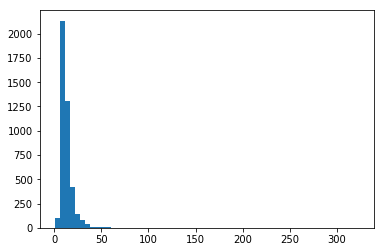

In [47]:
plt.hist(df[df['popularity'] > 0]['popularity'], bins=60);
plt.show()

## What's the range of average vote ratings?

/Users/chrischung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    4273.000000
mean        6.540417
std         0.832336
min         2.600000
25%         6.000000
50%         6.500000
75%         7.100000
max         8.800000
Name: vote_average, dtype: float64

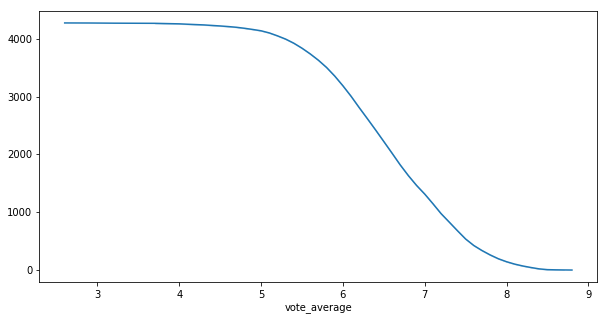

In [48]:
y = range(0, df['title'].count()) # plotting movie vote_average
x = df['vote_average']
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x,y);

x.describe() 

It looks like most of our data is under 7

In [49]:
df.head()

,budget,genres,id,imdb_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,gross_profit
0,13200000,"['Comedy', 'Drama', 'Romance']",19404,tt0112870,17.437,1995-10-20,100000000,190.0,Dilwale Dulhania Le Jayenge,8.8,2214,86800000.0
1,25000000,"['Drama', 'Crime']",278,tt0111161,35.028,1994-09-23,28341469,142.0,The Shawshank Redemption,8.7,15045,3341469.0
2,6000000,"['Drama', 'Crime']",238,tt0068646,29.433,1972-03-14,245066411,175.0,The Godfather,8.7,11486,239066411.0
3,11363000,"['Comedy', 'Thriller', 'Drama']",496243,tt6751668,176.819,2019-05-30,201055038,132.0,Parasite,8.6,4751,189692038.0
4,22000000,"['Drama', 'History', 'War']",424,tt0108052,19.641,1993-11-30,321365567,195.0,Schindler's List,8.6,9163,299365567.0


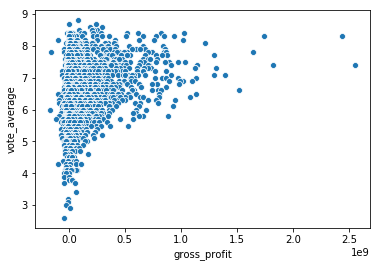

In [54]:
sns.scatterplot(df['gross_profit'], df['vote_average'])

## What release months or day of the week makes the best? The worst?